In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import keras.optimizers
from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Concatenate, Input
from sklearn.preprocessing import label_binarize
from textblob import TextBlob

from Code.Misc.helper import *
from Code.Misc.features import *
import tqdm
%matplotlib inline

physical_devices = tf.config.list_physical_devices('CPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

load = False

np.random.seed(1)
tf.random.set_seed(2)

In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\andre\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [12]:
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])

# Load in data
import pickle
with open("../Misc/Saved_data/data_collected_full.pickle", 'rb') as handle:
    data2 = pickle.load(handle)

In [13]:
MELD_PATH ='F:\Capstone Project\Capstone---RTSD-System\Data\MELD.Raw/train_features.npy'
MELD_dataset = np.load(MELD_PATH, allow_pickle=True)

MELD_x = MELD_dataset[1]

MELD_pol = []
MELD_pol_subj = []
for text in MELD_dataset[2]:
    tb = TextBlob(text)
    MELD_pol.append(tb.polarity)
    MELD_pol_subj.append([tb.polarity,tb.subjectivity])

labels = pd.DataFrame(np.array(MELD_dataset[0]).T, columns=["y"])

# order = ['ang', 'exc', 'neu', 'sad']
MELD_y = labels["y"].map({"neutral": [0,0,1,0], "sadness": [0,0,0,1],
                          "anger": [1,0,0,0], "surprise": [0,1,0,0]}).tolist()
MELD_y = np.array(MELD_y)
MELD_pol = np.array(MELD_pol)
MELD_pol_subj = np.array(MELD_pol_subj)

In [14]:
RAVDESS_PATH = "F:\Capstone Project\Capstone---RTSD-System\Data\RAVDESS/"
def read_revdess_data():
    attributes = ["Mod", "Type", "Emotion", "Emo_Intensity", "Stat",
              "Rep", "Actor_id", "Audio", "Framerate", "Sample_Width"]
    ravdess_list = []
    for actor in tqdm.tqdm(os.listdir(RAVDESS_PATH)):
        for f in os.listdir(RAVDESS_PATH + "/" + actor):
            wav_meta, samples = get_audio(RAVDESS_PATH + actor + "/", f)
            sample_framerate = wav_meta[2]
            sample_width = wav_meta[1]
            # remove file type
            if f.endswith('.wav'):
                f = f[:-4]

            # split file name into attributes
            file_attributes = list(map(int, f.split("-")))
            file_attributes.append(samples)
            file_attributes.append(sample_framerate)
            file_attributes.append(sample_width)

            ravdess_list.append(file_attributes)

    ravdess_df = pd.DataFrame(ravdess_list, columns=attributes)
    return ravdess_df

In [15]:
# this method is used to extract features from the input wav
def calculate_features(frames, freq):
    window_sec = 0.1
    window_n = int(freq * window_sec)

    st_f = stFeatureExtraction(frames, freq, window_n, window_n / 2)

    if st_f.shape[1] > 2:
        i0 = 1
        i1 = st_f.shape[1] - 1
        if i1 - i0 < 1:
            i1 = i0 + 1

        deriv_st_f = np.zeros((st_f.shape[0], i1 - i0), dtype=float)
        for i in range(i0, i1):
            i_left = i - 1
            i_right = i + 1
            deriv_st_f[:st_f.shape[0], i - i0] = st_f[:, i]
        return deriv_st_f
    elif st_f.shape[1] == 2:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f
    else:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f

def get_signal_pol(r, signal):
    # get text transcript from signal
    text = r.recognize_google(signal)
    # polarity is the average sentiment of the phrase that was spoken
    sentiment = TextBlob(text).polarity
    return sentiment

In [48]:
def get_model_acc(revdes_dataset, text_test, meld_dataset, model, output = True, MELD=True):

    progressbar = 0
    if output: progressbar = 1


    test_res = model.evaluate(text_test[0][0:], text_test[1][0:], verbose=progressbar)
    test_res = {"loss": test_res[0], "acc": test_res[1]}

    rev_res = model.evaluate(revdes_dataset[0][0:], revdes_dataset[1][0:], verbose=progressbar)
    rev_res = {"loss": rev_res[0], "acc": rev_res[1]}

    meld_res = model.evaluate(meld_dataset[0], meld_dataset[1], verbose=progressbar)
    meld_res = {"loss": meld_res[0], "acc": meld_res[1]}
    if output:
        print("Test set: Acc = %.3f, Loss = %.3f" % (test_res["acc"],test_res["loss"]))
        print("Revdess set: Acc = %.3f, Loss = %.3f" % (rev_res["acc"],rev_res["loss"]))
        print("MELD set: Acc = %.3f, Loss = %.3f" % (meld_res["acc"],meld_res["loss"]))

    return test_res, rev_res, meld_res

In [17]:
# set up training data
import speech_recognition as sr
from speech_recognition import AudioData

r = sr.Recognizer()

# generating training data take a while, here we load the training data into the np array from a file
x_train_file = "../Misc/Saved_data/x_test_speech.npy"

if load:
    with open(x_train_file, 'rb') as f:
        x_train_speech = np.load(f)
else:
    # set up the training set
    x_train_speech = []
    x_transcript = []
    x_transcript_pol_only = []

    counter = 0
    framerate = 16000
    for ses_mod in tqdm.tqdm(data2):
        x_head = ses_mod['signal']
        wav_meta = ses_mod['wav_meta']
        st_features = calculate_features(x_head, framerate)
        st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
        x_train_speech.append( st_features.T )

        x_transcript_pol_only.append(TextBlob(ses_mod['transcription']).polarity)

        x_transcript.append([TextBlob(ses_mod['transcription']).polarity,
                             TextBlob(ses_mod['transcription']).subjectivity])

    x_train_speech = np.array(x_train_speech)
    x_transcript = np.array(x_transcript)
    x_transcript_pol_only = np.array(x_transcript_pol_only)

    # save model after it has been trained
    with open(x_train_file, 'wb') as f:
        np.save(f, x_train_speech)

x_train_speech.shape


100%|██████████| 4936/4936 [04:48<00:00, 17.12it/s]


(4936, 100, 34)

In [18]:
# set up testing data
ravdess_df = read_revdess_data()

# group surprised and happy
ravdess_df["Emotion"].replace({3: 8}, inplace=True)
# group disgust and anger
ravdess_df["Emotion"].replace({7: 5}, inplace=True)

#ravdess_df = ravdess_df.loc[ravdess_df['Emotion'] == 3, 'Emotion'] = 8

# extract subset of emotions
# 1 = neutral, 4 = sad, 5 = angry, 8 = surprised (lets use this as excited)
ravdess_df = ravdess_df.loc[
    ravdess_df['Emotion'].isin([1, 4, 5, 8])]

# select only speaking samples
ravdess_df = ravdess_df.loc[
    ravdess_df['Type'] == 1]

# refactor emotions to be in the format of the training data
# order = ['ang', 'exc', 'neu', 'sad']
ravdess_df["Emotion"] = ravdess_df['Emotion'].map({1: [0,0,1,0], 4: [0,0,0,1],
                                                   5: [1,0,0,0], 8: [0,1,0,0]})
print("samples: " + str(ravdess_df.shape))
r = sr.Recognizer()

revdess_X = []
revdess_X_text_auto_pol = []
revdess_X_text_auto = []
revdess_auto_text_transcription = {}
test_df = ravdess_df
for _, row in tqdm.tqdm(test_df.iterrows()):
    st_features = calculate_features(row["Audio"], row["Framerate"])
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    revdess_X.append( st_features.T )

    audio_wav = AudioData(frame_data = x_head,
                          sample_rate = row["Framerate"],
                          sample_width = row['Sample_Width'])
    try:
        auto_transcription = r.recognize_google(audio_wav)
        textblob_out = TextBlob(auto_transcription)
        revdess_X_text_auto.append([textblob_out.polarity, textblob_out.subjectivity])
        revdess_X_text_auto_pol.append(textblob_out.polarity)
        revdess_auto_text_transcription.append(auto_transcription)
        print(auto_transcription)
    except:
        revdess_X_text_auto.append([0.0, 0.0])
        revdess_X_text_auto_pol.append(0.0)

revdess_X = np.array(revdess_X)
revdess_X_text_auto = np.array(revdess_X_text_auto)
revdess_X_text_auto_pol = np.array(revdess_X_text_auto_pol)
revdess_auto_text_transcription = np.array(revdess_auto_text_transcription)

revdess_list = ravdess_df["Emotion"]
revdess_Y = []
for y in revdess_list:
    revdess_Y.append(y)
revdess_Y = np.array(revdess_Y)

print("X: " + str(revdess_X.shape) + "\nY: " + str(revdess_Y.shape))

100%|██████████| 24/24 [00:04<00:00,  5.95it/s]
1056it [08:38,  2.04it/s]


samples: (1056, 10)
X: (1056, 100, 34)
Y: (1056, 4)


In [19]:
# split labels from training data
Y_raw =[]
for ses_mod in data2:
    Y_raw.append(ses_mod['emotion'])

#converts labels into a one hot encoded version
Y = label_binarize(Y_raw ,emotions_used)

Y.shape

F:\Program Files\Ananconda\envs\Tersorflow-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['ang' 'exc' 'neu' 'sad'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(4936, 4)

In [20]:
def lstm_model(optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [21]:
#model_lstm = load_model("F:\Capstone Project\Capstone---RTSD-System\Code\Misc\Saved_data\Trained_models/2_layer_LSTM.pickle")

model_lstm = lstm_model('Adam')
time_start = time.time()
hist = model_lstm.fit(x_train_speech, Y,
                     batch_size=100, epochs=40, verbose=0, shuffle = True,
                     validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

time elapsed: 54.10798764228821


In [22]:
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 512)          1120256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 2,041,348
Trainable params: 2,041,348
Non-trainable params: 0
______________________________________________

In [23]:
test_res, rev_res, meld_res = get_model_acc((revdess_X, revdess_Y),
                                  (x_train_speech, Y), (MELD_x, MELD_y), model_lstm)

24/24 [==============================] - 0s 10ms/step - loss: 1.1991 - accuracy: 0.5450
Test set: Acc = 0.523, Loss = 1.038
Revdess set: Acc = 0.283, Loss = 1.612
MELD set: Acc = 0.545, Loss = 1.199


In [24]:
result = model_lstm.predict(revdess_X)
# get prediction values for training data
label = tf.argmax(result, axis = 1)

In [25]:
class audio_only_model(Model):
    def __init__(self, optimizer="Adam"):
        super(audio_only_model, self).__init__()

        # the first branch operates on the audio input
        self.model_audio = Sequential()
        self.model_audio.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
        self.model_audio.add(LSTM(256, return_sequences=False))
        self.model_audio.add(Dense(512))
        self.model_audio.add(Activation('relu'))

        # apply a FC layer and then a regression prediction on the
        # combined outputs
        self.dense = Dense(4, activation="softmax")


    def call(self, inputs):

        layer_output = self.model_audio(inputs)
        out = self.dense(layer_output)
        return out

    def extract_audio_layer(self):
        return self.model_audio

In [26]:
audio_only_model= audio_only_model(optimizer="Adam")
audio_only_model.compile(loss='categorical_crossentropy',
                      optimizer="Adam", metrics=['accuracy'])

time_start = time.time()
with tf.device('/gpu:0'):
    hist_audio_only = audio_only_model.fit(x_train_speech, Y,
                         batch_size=100, epochs=40, verbose=0, shuffle = True,
                         validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

time elapsed: 49.410011768341064


In [27]:
save_model = True
if save_model:
    PATH_TO_weights = "../Misc/Saved_data/Trained_models/Weights/Audio_only/model"
    audio_only_model.save(PATH_TO_weights)

INFO:tensorflow:Assets written to: ../Misc/Saved_data/Trained_models/Weights/Audio_only/model\assets


INFO:tensorflow:Assets written to: ../Misc/Saved_data/Trained_models/Weights/Audio_only/model\assets


In [28]:
test_res, rev_res, meld_res = get_model_acc((revdess_X, revdess_Y), (x_train_speech, Y),
                                            (MELD_x, MELD_y), audio_only_model)

24/24 [==============================] - 0s 10ms/step - loss: 1.3111 - accuracy: 0.4819
Test set: Acc = 0.573, Loss = 0.950
Revdess set: Acc = 0.339, Loss = 1.731
MELD set: Acc = 0.482, Loss = 1.311


In [29]:
class audio_text_model(Model):
    def __init__(self, trained_audio_model:Model, pol_only = True, optimizer="Adam"):
        super(audio_text_model, self).__init__()

        # the first branch operates on the audio input
        self.model_audio = trained_audio_model
        self.model_audio.trainable = False

        # the second branch operates on the transcription input
        if pol_only: self.model_text = Dense(1, activation="relu")

        else: self.model_text = Dense(2, activation="relu")

        # apply a FC layer and then a regression prediction on the
        # combined outputs
        self.dense = Dense(4, activation="softmax")


    def call(self, input) :
        inputAudio = input[0]
        inputText = input[1]
        audio_y = self.model_audio(inputAudio)
        text_y = self.model_text(inputText)

        # combine the output of the two branches
        combined = Concatenate(axis=1)([audio_y, text_y])

        out = self.dense(combined)
        return out

In [30]:
audio_layer = audio_only_model.extract_audio_layer()

multi_modal_model_pol = audio_text_model(audio_layer, optimizer="Adam")
multi_modal_model_pol.compile(loss='categorical_crossentropy',
                      optimizer="Adam", metrics=['accuracy'])

time_start = time.time()
with tf.device('/gpu:0'):
    hist_multi_pol_only = multi_modal_model_pol.fit([x_train_speech, x_transcript_pol_only], Y,
                         batch_size=100, epochs=40, verbose=0, shuffle = True,
                         validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

time elapsed: 26.822988748550415


In [31]:
test_res, rev_res, meld_res = get_model_acc(([revdess_X, revdess_X_text_auto_pol], revdess_Y),
                                  ([x_train_speech, x_transcript_pol_only], Y),
                                  ([MELD_x, MELD_pol], MELD_y), multi_modal_model_pol)

24/24 [==============================] - 0s 10ms/step - loss: 1.3369 - accuracy: 0.4940
Test set: Acc = 0.586, Loss = 0.930
Revdess set: Acc = 0.344, Loss = 1.879
MELD set: Acc = 0.494, Loss = 1.337


In [32]:
save_model = False
if save_model:
    PATH_TO_weights = "../Misc/Saved_data/Trained_models/Weights/Audio_Text/model"
    multi_modal_model_pol.save(PATH_TO_weights)

In [33]:
audio_layer = audio_only_model.extract_audio_layer()

multi_modal_model= audio_text_model(audio_layer, pol_only = False, optimizer="Adam")
multi_modal_model.compile(loss='categorical_crossentropy',
                      optimizer="Adam", metrics=['accuracy'])

time_start = time.time()
with tf.device('/gpu:0'):
    hist_multi = multi_modal_model.fit([x_train_speech, x_transcript], Y,
                         batch_size=100, epochs=40, verbose=0, shuffle = True,
                         validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

time elapsed: 26.59700036048889


In [34]:
test_res, rev_res, MELD_res = get_model_acc(([revdess_X, revdess_X_text_auto], revdess_Y),
                                  ([x_train_speech, x_transcript], Y),
                                  ([MELD_x, MELD_pol_subj], MELD_y), multi_modal_model)

24/24 [==============================] - 0s 10ms/step - loss: 1.3445 - accuracy: 0.4980
Test set: Acc = 0.587, Loss = 0.928
Revdess set: Acc = 0.346, Loss = 1.915
MELD set: Acc = 0.498, Loss = 1.345


In [35]:
if save_model:
    PATH_TO_weights = "../Misc/Saved_data/Trained_models/Weights/Audio_Text/model"
    multi_modal_model.save(PATH_TO_weights)

In [36]:
class audio_text_model_denser(Model):
    def __init__(self, trained_audio_model:Model, pol_only = True, output_layers=3, optimizer="Adam"):
        super().__init__()

        # the first branch operates on the audio input
        self.model_audio = trained_audio_model
        self.model_audio.trainable = False

        # the second branch operates on the transcription input
        if pol_only: self.model_text = Dense(1, activation="relu", name = "text_input_pol")
        else: self.model_text = Dense(2, activation="relu", name = "text_input")

        # apply a FC layer and then a regression prediction on the
        # combined outputs
        self.dense = Sequential(name = "output")
        input_prev = 512
        for o_layer in range(0, output_layers):
            input_prev = int(input_prev/2)
            self.dense.add(Dense(input_prev))
        self.dense.add(Dense(4, activation="softmax")) # add final classification layer

    def call(self, input) :
        inputAudio = input[0]
        inputText = input[1]
        audio_y = self.model_audio(inputAudio)
        text_y = self.model_text(inputText)

        # combine the output of the two branches
        combined = Concatenate(axis=1)([audio_y, text_y])

        out = self.dense(combined)
        return out

In [45]:
denser_histories = []
accuracy_per_model = []
for depth in tqdm.tqdm(range(0, 7)):
    # audio_text_model_denser
    audio_layer = audio_only_model.extract_audio_layer()

    cust_adam = keras.optimizers.Adam(learning_rate = 1e-4)
    multi_modal_model_denser_pol = audio_text_model_denser(audio_layer, optimizer="Adam", output_layers=depth)
    multi_modal_model_denser_pol.compile(loss='categorical_crossentropy',
                          optimizer=cust_adam, metrics=['accuracy'])

    time_start = time.time()
    with tf.device('/gpu:0'):
        hist_multi_denser_pol_only = multi_modal_model_denser_pol.fit([x_train_speech, x_transcript_pol_only], Y,
                             batch_size=100, epochs=50, verbose=0, shuffle = True,
                             validation_split=0.2)


    test_res, rev_res, MELD_res = get_model_acc(([revdess_X, revdess_X_text_auto_pol], revdess_Y),
                                                ([x_train_speech, x_transcript_pol_only], Y),
                                                ([MELD_x, MELD_pol], MELD_y),
                                                multi_modal_model_denser_pol, output= False)

    denser_histories.append(("d-"+ str(depth), hist_multi_denser_pol_only))
    accuracy_per_model.append({"model_depth": depth,"test_res": test_res,
                               "rev_res":rev_res,
                               "MELD_res":MELD_res})

100%|██████████| 7/7 [04:56<00:00, 42.32s/it]


24/24 [==============================] - 0s 12ms/step - loss: 1.3748 - accuracy: 0.5074


depth: 0 test_res: {'loss': 0.945375919342041, 'acc': 0.5761750340461731} rev_res: {'loss': 1.6116307973861694, 'acc': 0.3380681872367859} MELD_res: {'loss': 1.2884095907211304, 'acc': 0.4885905981063843}
depth: 1 test_res: {'loss': 0.9254918098449707, 'acc': 0.5881280303001404} rev_res: {'loss': 1.874912977218628, 'acc': 0.344696968793869} MELD_res: {'loss': 1.3767054080963135, 'acc': 0.4899328947067261}
depth: 2 test_res: {'loss': 0.9231125116348267, 'acc': 0.5873176455497742} rev_res: {'loss': 1.8834556341171265, 'acc': 0.3399621248245239} MELD_res: {'loss': 1.3726619482040405, 'acc': 0.4993288516998291}
depth: 3 test_res: {'loss': 0.9240032434463501, 'acc': 0.5840761661529541} rev_res: {'loss': 1.853906273841858, 'acc': 0.33617424964904785} MELD_res: {'loss': 1.37710440158844, 'acc': 0.5073825716972351}
depth: 4 test_res: {'loss': 0.9223030209541321, 'acc': 0.5861021280288696} rev_res: {'loss': 1.8836256265640259, 'acc': 0.33712121844291687} MELD_res: {'loss': 1.3759816884994507, '

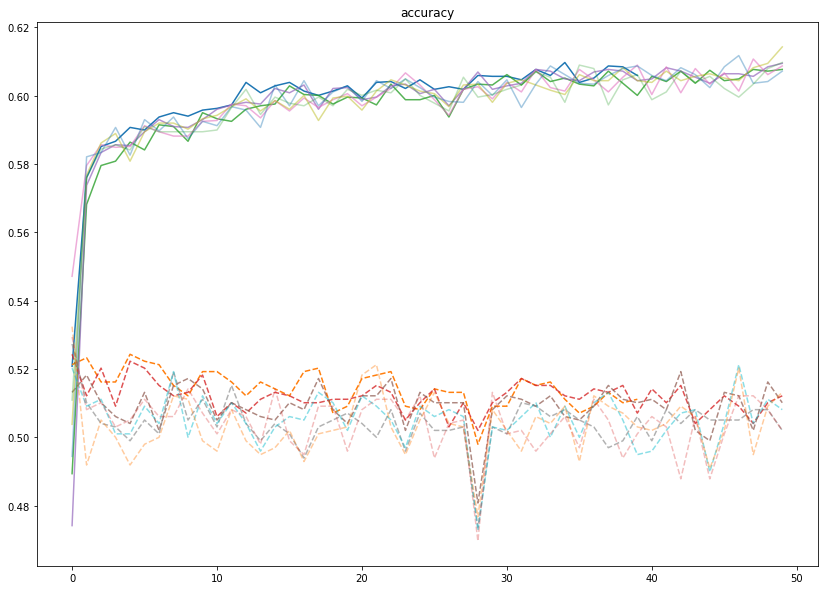

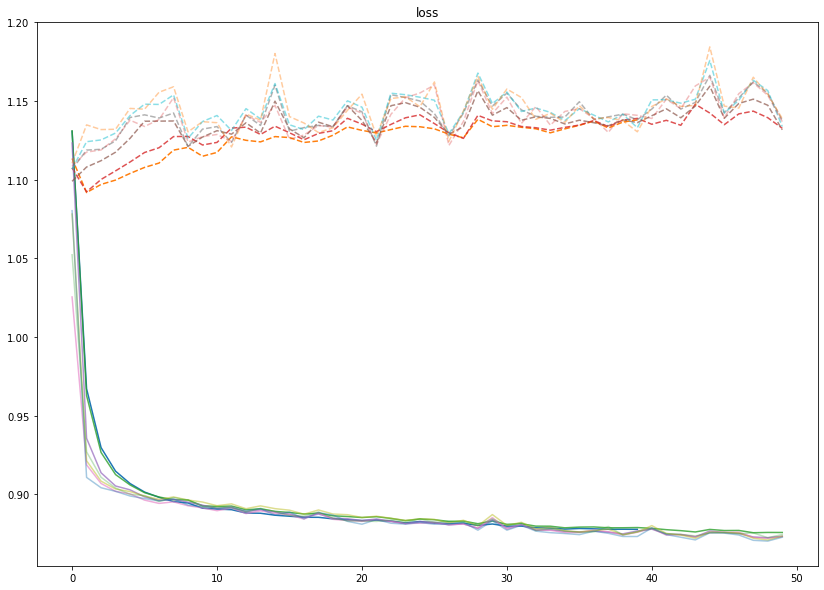

In [49]:
for v in ["accuracy", "loss"]:
    plt.figure(figsize=(14,10))
    #plot baseline (single layer output)
    plt.plot(hist_multi.history[v], label="baseline acc")
    plt.plot(hist_multi.history['val_' + v], "--", label="baseline val_acc")

    #plot test results (multi_layer output)
    alpha_int = 0.8
    for hist_ in denser_histories[1:]: #[denser_histories[0], denser_histories[6]]:
        plt.plot(hist_[1].history[v], label=hist_[0] + " acc", alpha= alpha_int)
        plt.plot(hist_[1].history['val_' + v], "--", label=hist_[0] + " val_acc", alpha= alpha_int)
        alpha_int -= 0.1

    #plt.legend()
    plt.title(v)
    plt.show

In [56]:
for m in accuracy_per_model:
    acc_out = "depth: " + str(m["model_depth"]) + "\n"
    acc_out += "\ttest_res: " + str(m["test_res"])+ "\n"
    acc_out += "\trev_res: " + str(m["rev_res"])+ "\n"
    acc_out += "\tMELD_res: " + str(m["MELD_res"])+ "\n"

    print(acc_out)

depth: 0
	test_res: {'loss': 0.945375919342041, 'acc': 0.5761750340461731}
	rev_res: {'loss': 1.6116307973861694, 'acc': 0.3380681872367859}
	MELD_res: {'loss': 1.2884095907211304, 'acc': 0.4885905981063843}

depth: 1
	test_res: {'loss': 0.9254918098449707, 'acc': 0.5881280303001404}
	rev_res: {'loss': 1.874912977218628, 'acc': 0.344696968793869}
	MELD_res: {'loss': 1.3767054080963135, 'acc': 0.4899328947067261}

depth: 2
	test_res: {'loss': 0.9231125116348267, 'acc': 0.5873176455497742}
	rev_res: {'loss': 1.8834556341171265, 'acc': 0.3399621248245239}
	MELD_res: {'loss': 1.3726619482040405, 'acc': 0.4993288516998291}

depth: 3
	test_res: {'loss': 0.9240032434463501, 'acc': 0.5840761661529541}
	rev_res: {'loss': 1.853906273841858, 'acc': 0.33617424964904785}
	MELD_res: {'loss': 1.37710440158844, 'acc': 0.5073825716972351}

depth: 4
	test_res: {'loss': 0.9223030209541321, 'acc': 0.5861021280288696}
	rev_res: {'loss': 1.8836256265640259, 'acc': 0.33712121844291687}
	MELD_res: {'loss': 1.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


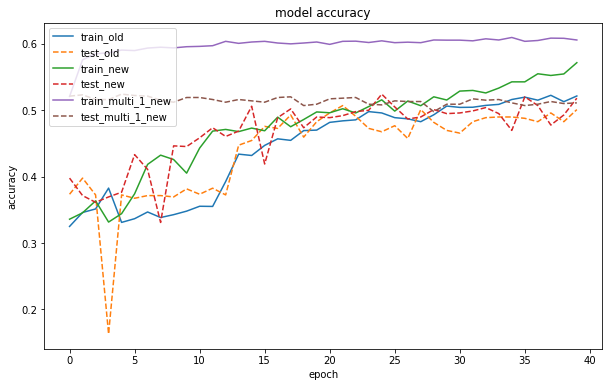

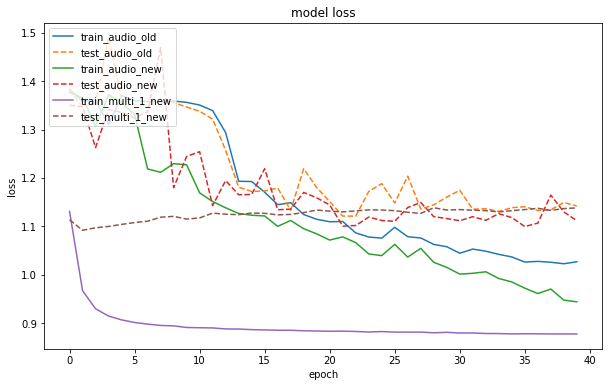

In [57]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'], "--")
plt.plot(hist_audio_only.history['accuracy'])
plt.plot(hist_audio_only.history['val_accuracy'], "--")
plt.plot(hist_multi.history['accuracy'])
plt.plot(hist_multi.history['val_accuracy'], "--")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_old', 'test_old',
            'train_new', 'test_new',
           'train_multi_1_new', 'test_multi_1_new'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'], "--")
plt.plot(hist_audio_only.history['loss'])
plt.plot(hist_audio_only.history['val_loss'], "--")
plt.plot(hist_multi.history['loss'])
plt.plot(hist_multi.history['val_loss'], "--")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_audio_old', 'test_audio_old',
            'train_audio_new', 'test_audio_new',
            'train_multi_1_new', 'test_multi_1_new'], loc='upper left')
plt.show()

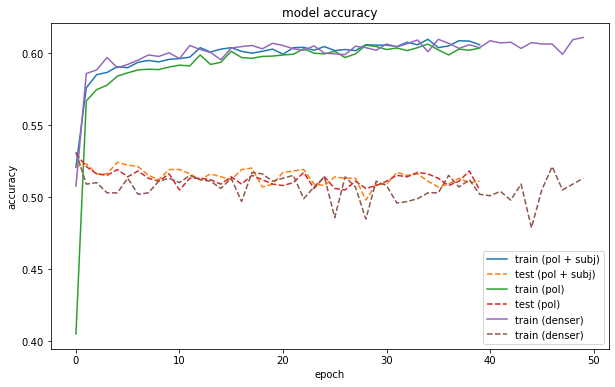

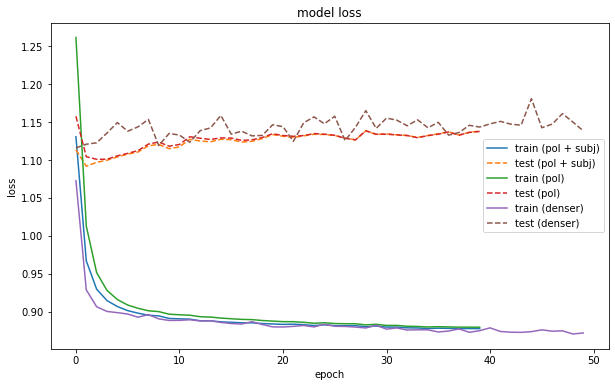

In [41]:
# summarize history for accuracy
plt.plot(hist_multi.history['accuracy'],  label = 'train (pol + subj)')
plt.plot(hist_multi.history['val_accuracy'], "--",  label = 'test (pol + subj)')
plt.plot(hist_multi_pol_only.history['accuracy'],  label = 'train (pol)')
plt.plot(hist_multi_pol_only.history['val_accuracy'], "--",  label = 'test (pol)')
plt.plot(hist_multi_denser_pol_only.history['accuracy'],  label = 'train (denser)')
plt.plot(hist_multi_denser_pol_only.history['val_accuracy'], "--",  label = 'train (denser)')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
# summarize history for loss
plt.plot(hist_multi.history['loss'], label = 'train (pol + subj)')
plt.plot(hist_multi.history['val_loss'], "--", label = 'test (pol + subj)')

plt.plot(hist_multi_pol_only.history['loss'], label = 'train (pol)')
plt.plot(hist_multi_pol_only.history['val_loss'], "--", label = 'test (pol)')

plt.plot(hist_multi_denser_pol_only.history['loss'], label = 'train (denser)')
plt.plot(hist_multi_denser_pol_only.history['val_loss'], "--", label = 'test (denser)')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
